# Demo - Probabilistic Fourier with AR model on coefficients

This file provides an demo of the probabilistic Fourier framework as outline in "Bayesian spectrum estimation of unevenly sampled data" - Qi et al.

$$ {\bf{s}}_t = {\bf{s}}_{t-1} + {\bf{w}}_t $$
$$ {\bf{y}}_t = C^\top {\bf{s}}_t + {\bf{v}}_t $$

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using FFTW
using LAR
using LAR.Node
using Distributions

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
;

## Settings

In [2]:
# data loading
sound_file = "../data/woman.wav"   # specify sound location
fs_desired = 8000                  # specify desired sampling frequency

# input buffer parameters
step_size = 30                      # specify step size of buffer
buffer_size = 30                    # specify size of buffer

# probabilistic fourier parameters 
var_observation = 1e-3               # specify observation noise var
freq_bins = 15
freq = collect(fs_desired/(2*(freq_bins+1)):fs_desired/(2*(freq_bins+1)):(fs_desired/2-fs_desired/(2*(freq_bins+1))))

# AR modelling
AR_order = 2
iterations = 5
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[1*fs_time+1:4*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)
x_time_clean = x_time
x_time = x_time_clean + rand(Distributions.Normal(0, sqrt(var_observation)), length(x_time_clean))

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQCcVbi9byvHvbS8AL4z2sq9L6dAvYXeMDukWUw9TosNPkEuTD7hYXc+EiOKPhcfdD5blIA+06IVPm5Ux7xMXi29PqG7vI5Sxr0jsTq+6aY9vkSxL70c/Ei8RQxzvB6dzLxOAuE9jDKePXeCPj1ghY08mIetvNYihr3y87W9SoTjvfuqJ746/aa91vKevWLSMbzkpqG73JTjPKVV0z21r34+CAcqPvm6UD5gKIg+PQqHPlmiWT63bIE9zyOAvGEvHr2+nQW+WBRrvsFbQr7FcfO97OqdveyGMb1Efdq9fLGMPY2AMD2FFMg8FrESPWdK/7xMJsC8vF4Tveh10b3Ub9O9PNo7vk/gW70g+GK97U1xvRYQgz3wIxA+M2VPPuYMMD5/BYo+6I+ZPj4lGz7qfTY9nhVIPEhfAD0pHv69rioRvsvSfr4oAze+TJizvRHAl71d2LK9/As/PBnE3D0uo809UIFvvDzjwTwo5Sk8AzD4PMPHRL3/PAa+Ax0WvqXho71wmee9n3Vmvd2s2jydLMo93/YHPjN+QD5fq4A+2bCAPoBMgj6jH9s90/NrPbLTDT0piBA8y1kSvk9uOb693za+soqnvYovyr2rhAS+GIAbvTbFgz1oFJw9e9uZPWjbCr32OD89unnmulpXy7xjF8O9+6OqvWzvljvMngk7xT06PLLY6z1QHtw9l/JCPm6wRj6HamQ+i4AMPhNBoz3F0t49ImlDvXbwD76X2E6+aQ3mvZipB75piDy+IeoivranI72EESU9Tri/PHT9zD3QbuE90UXxPPMknj2Peac8psbqvS4VoL1O27y9JWavvcW5Er4pNTm+N8M8u5HqLbuUdEc9Bi2CPVTn9D241fA98AwRPmUgoT2vRwo+8alJPXBNhz0xBLe9IQpqvSLgOb1xK8W9Uoy9vfWgkL35UFO9dDfHvRB0Sb1jWtc8jEYAPCOfILwWX4U9f5SfvPJum7zFGgC9bQdmug7x9zxh3eg9aWu3PXVPDj5R6GE+fo9xPjnVUj6TzFI95IoKPbRmuLxrJIu9BkJjvgABUL67eqS9SrQHvivB672Glca9pgkNPdJtqz2Lhck9OW4KPWR7Fj6Ltws+CbVOPWN0oT1Ifu68U3WavUHgvb00JQK+Tus/vtatkr0Xl3y8sku7vWYR7DwLcrK8iGOuPa2lFzwpi3+884mzPYyLVDuW6/i629VCvQoqCjyZoV48dRPMvIh/5zxcQH29cYxCvZJlnjyOLQ88Oqx3us2YxTyqRem8XJx6PVISKDwO4Cu9jkVgvb5sxLxZdty7FhB4ux7uXjwVwIm8L3xbPcgbrz0Uu+I95/OQPe6z7TzxVoU9b75mPfX5AD0JbYE790NOvJ3Hmb3ArZi8wpGFvSoe87txD0y6WxctvZ81J70h6gG9hcuPvBF2BT0DYZa8ZNOkvC03hDwtkzm8M4+FuzcYNz03yDQ9fHXqPfb7lz3Wx209XVIPPjDMTD0Rhog9+oqbPMljdjyHzYu9rOmKvTFi670KDrO9EtGvvU0X6r3RXui9HRKwvQ8wo71dtDK9iFiVPIUHUbu0kGK8louWPJz7fz07O249vXJiPRyJCD4VfHw9sKQEPhxr8D21kwI9vjzFPVG3vT1PHDG8De4JvaL4Br6KF5q9UyUHvvL2Qb4pER6+LQeQvbytILyXQ3i9SbCxPNKmRTuqzko9h5GoPZGLCj17Jek9lKZMPbDeyD3aVe09dNbSPY9gJD58ajA+8iEqPCkXizwL8Ck95fpqvYONMr6ZbN292LC3vUF8qL16h4C9KGbJvY1olTytlMC86rTruw3KtT2cnpI9Qnh0PXDcDbxktKs9trM1Pe8rlL0kwFe9sYWbvOUgNLl1N3y9WaUuvWGGgL1R+Xq8O6oRPK/qPDqnRLC8wyj7PJwweb1+RMo7YBwJPEQxfzpdEcE7fYE2POReCDzVdW48ErMbPB89srssFR48gXhHvTqHOz3GP7G9HIqcvTF3kr2kf0q8NlhLPJf1/DzDu167qhSxvHzndT1KVKI7nyKJPKkDmzx5yRi9kHbiPJnsFbygf2C91KJnPKO/kjvBvU49usQNPVGUj70LV8m9hAkQO80FIT0jdbO7w1uCu+KSvLwamGM8GJLwOywbmLsOB6g7i0i+PFVKvT2bm3I9L0unvPR9STwx9GE9lDgEPeT3wDvTcl88nOlSPfo6ury/nH08wq0VPG4XprwMfaY8/kKDPFxFqrzMH1y7MF49PCSTJLuSOmK8veemPJxzATy2rG68X3bvPP7B9Dzim3w8XaILvCjP7DzmGka8Yt6ZPecwyDzGzF+8Kzf7PEso8Lsmu5c943+qPR82ZLw5Q1w9bqwXvMj2vzxMKqI8QUJWPZ3cwDxrhKA77XLQPWxjtrzwzjK9jO5tvCH1vrxiTP+6QJd1vTitr72uteu6K4cBPT3SnLyFqPW8TwLoPA8OrTuz/gO83qSzuxlUTj0Z89G8tcwwvR6tjzzj7gI9Yz+ivFdXYbwGFYY8SWxnuoQS1rzieEy7ptLGPCC60Lwdvts8MJKyvKS4sLrlram6RPHyPKgGgL05nTY9HuANPPuykL1++l48wH7hvDzzv7yerN+7H+bpvL2dR7x9iUc8uFC1PGGGqrwYVhi8fF51OodzZrvW+Zo7xaoFPcBlhL0n0Vs8hKrCPLVTcT0Y3ro83mb8vMXdI73MEPQ8XUTxOnMUBL2hedU7GLM/vEZYtjrdS/k8hn+APJso1rsds0a8BdANvMenTrwyV848vxwQO5uFFD1q+S69P8NcvQk/Wb1d7/C8VUwDvTYzCjlQoCO81gOevVmxSryPmIS7gkCBvGOSirzh1xK9jRI8vRCQDz3PrUg80bRGvT684zyufgi93mtYvaGqRD3lmyO9R+i2PIqHET19MDC8rx4hO49XNb0jIwU938dPuwPkmLxHqP07PYx0vD7FY7yzt1C9FJm2O7i4YD2sdB28qgRGPDjaprzSy2y9mdxHvWQzCDz1NvW86vjGvJOFSTzE/vC7jodDPceuhTxnnxy7JFKVueHhvryk7/C8Ppo2vbinZjxtyqU5vieCvCSTj7vPVfC7e6AiPdX3ubmtOTG96vWovBHxnTymh6s7zaeFPWudE7uGO/Y7K8A4PYil3zxD3KI95/6Lvcvg5bzzJ4G8n4KavK2ghTtVTuE8TAQBPEeGBz3G4AM9iw0BvVn1P729bE29aASavBEMCD1vGw+8SK+PPRPEAT0UJr28OO8RO1nfrjyWR1k8XjFBPCYRMj18C+28HSdiu1ghkzxthUs8rxeMvDxIlTsayzI87w76PLvKfru4j7u9MRQmPXbuQz0ujkC75D+OOzf/Rr28G0c8IyM9vXwygby/tSK8Pz0ZvTXVj726U8s8wV8ovXMQ+7xgk5+8MapnPO8997zv6RY8dwbfu9CDbrvZ5n28mm6ZPMTpFj3NME07lRGiPGRCQDz7Zim9P0auO+9yQjym6fM8Pul/vG876byIeXQ92CwMO+9vgDzpao+8BBtPPOsE/jvfVwO9tpCKu89+F72ydnm7n2sFPcsA6zmWX6y807UdvN8gkbxYo928vhQnPHaUL71wev88QwPbvPBFHbyXru87efYHvSWzDD0uOie99g45vF3N/zxdB/E83xNMvdNtWT0ZoRS7x/kBPZ44zDx94kI9XV9HvaERzDw5oWw80BewPJh2pTyYXTQ9X0tYPM1KBr3OZRI8N/dGPbTL4bpS1mk8Pkf5PF/qYDzFsyk9c9jtu0aZ6rwCcyg9WcBjPGqjUjoSHDa9ncj+vEKEsru3BRc9RlxnveqnLjwp7Y67urRUvIgKVbx6cXs9XUqyO2CDTT1S5qO8kBKJPBubsDxkW

## Visualize data

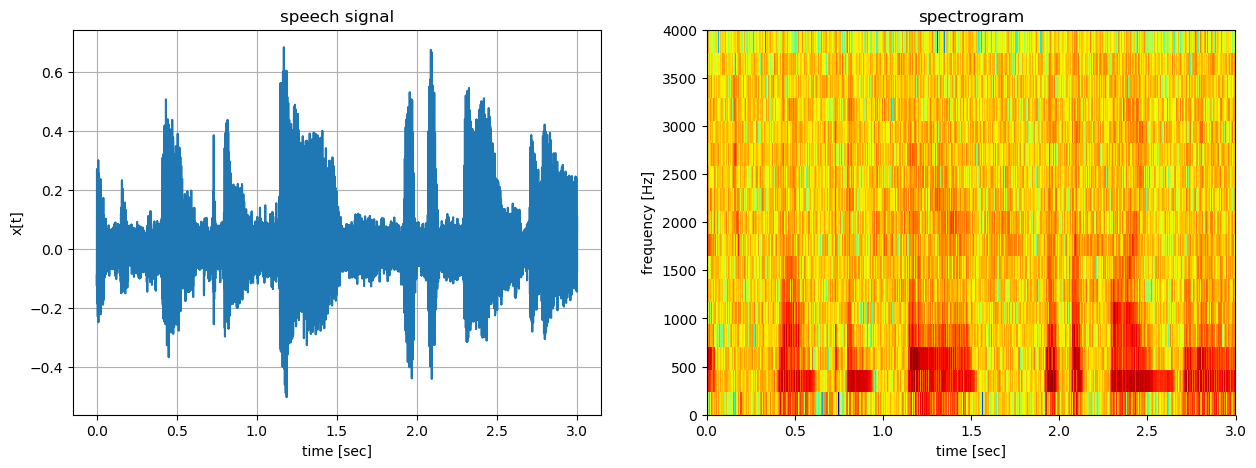

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 32, 0, fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Specify generative model

In [5]:
# create factor graph
fg = FactorGraph()

# placeholders
z_min = Array{Variable,1}(undef, 2*length(freq))
γ = Array{Variable,1}(undef, 2*length(freq))
θ = Array{Variable,1}(undef, 2*length(freq))
z = Array{Variable,1}(undef, 2*length(freq))

# specify observation noise
@RV v ~ GaussianMeanVariance(zeros(buffer_size), var_observation*Ic(buffer_size))

# specify previous hidden state (spectral component buffer)
for k = 1:2*length(freq)
    @RV [id=pad(:z_min,k)] z_min[k] ~ GaussianMeanVariance(placeholder(pad(:μ_z_min, k), dims = (AR_order,)),
                                        placeholder(pad(:Σ_z_min, k), dims = (AR_order, AR_order)))
    @RV [id=pad(:γ,k)] γ[k] ~ ForneyLab.Gamma(placeholder(pad(:a_γ,k)), placeholder(pad(:b_γ,k)))
    @RV [id=pad(:θ,k)] θ[k] ~ GaussianMeanVariance(placeholder(pad(:μ_θ,k), dims=(AR_order,)), placeholder(pad(:Σ_θ,k), dims=(AR_order, AR_order)))
    @RV [id=pad(:z,k)] z[k] ~ LAR.Autoregressive(θ[k], z_min[k], γ[k])
end

# specify Fourier matrix
Ceme1 = Array{Variable,1}(undef, 2*length(freq))
for k=1:2*length(freq)
    @RV Ceme1[k] 
    placeholder(Ceme1[k], pad(:Ceme1,k), dims = (buffer_size, AR_order))
end

# specify observations
@RV x = sum(Ceme1.*z)
@RV y = x + v

# create placeholder for observations
placeholder(y, :y, dims = (buffer_size,))

# draw factor graph
ForneyLab.draw(fg)
ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 11959121362499876828 -->
 11959121362499876828 
 
 + 
 addition_8 
 
<!-- 13288933275507646547 -->
 13288933275507646547 
 
 + 
 addition_7 
 
<!-- 11959121362499876828--13288933275507646547 -->
 11959121362499876828--13288933275507646547 
 
 variable_37 
 1 out 
 2 in1 
 
<!-- 9276116834098330253 -->
 9276116834098330253 
 
 × 
 multiplication_9 
 
<!-- 11959121362499876828--9276116834098330253 -->
 11959121362499876828--9276116834098330253 
 
 variable_9 
 1 out 
 3 in2 
 
<!-- 641319365807995726 -->
 641319365807995726 
 
 placeholder_μ_z_min_17 
 
<!-- 812161263251688044 -->
 812161263251688044 
 
 × 
 multiplication_24 
 
<!-- 2326111481292518387 -->
 2326111481292518387 
 
 AR 
 autoregressive_24 
 
<!-- 812161263251688044--2326111481292518387 -->
 812161263251688044--2326111481292518387 
 
 z_24 
 1 y 
 2 in1 
 
<!-- 310085582114882132 -->
 310085582114882132 
 
 placeholder_Ceme1_24 
 
<!-- 812161263251688044--310085582114882132 -->
 812161263251688044--310085582114882132 
 
 Ceme1_24 
 1 out 
 3 a 
 
<!-- 7141349745972794455 -->
 7141349745972794455 
 
 placeholder_Ceme1_21 
 
<!-- 491019807008615376 -->
 491019807008615376 
 
 placeholder_μ_z_min_14 
 
<!-- 5510542433807241719 -->
 5510542433807241719 
 
 AR 
 autoregressive_10 
 
<!-- 14009145978291902056 -->
 14009145978291902056 
 
 𝒩 
 gaussianmeanvariance_20 
 
<!-- 5510542433807241719--14009145978291902056 -->
 5510542433807241719--14009145978291902056 
 
 z_min_10 
 1 out 
 2 x 
 
<!-- 14533053614084653380 -->
 14533053614084653380 
 
 Gam 
 gamma_10 
 
<!-- 5510542433807241719--14533053614084653380 -->
 5510542433807241719--14533053614084653380 
 
 γ_10 
 1 out 
 4 γ 
 
<!-- 10532828996665701396 -->
 10532828996665701396 
 
 𝒩 
 gaussianmeanvariance_21 
 
<!-- 5510542433807241719--10532828996665701396 -->
 5510542433807241719--10532828996665701396 
 
 θ_10 
 1 out 
 3 θ 
 
<!-- 9572670966843784980 -->
 9572670966843784980 
 
 placeholder_a_γ_25 
 
<!-- 13028240503348784954 -->
 13028240503348784954 
 
 placeholder_μ_z_min_08 
 
<!-- 18313973754514074291 -->
 18313973754514074291 
 
 placeholder_Ceme1_12 
 
<!-- 11089641311083726815 -->
 11089641311083726815 
 
 𝒩 
 gaussianmeanvariance_37 
 
<!-- 17654833743380618513 -->
 17654833743380618513 
 
 placeholder_μ_θ_18 
 
<!-- 11089641311083726815--17654833743380618513 -->
 11089641311083726815--17654833743380618513 
 
 μ_θ_18 
 1 out 
 2 m 
 
<!-- 11349395736405295895 -->
 11349395736405295895 
 
 placeholder_Σ_θ_18 
 
<!-- 11089641311083726815--11349395736405295895 -->
 11089641311083726815--11349395736405295895 
 
 Σ_θ_18 
 1 out 
 3 v 
 
<!-- 2555924396745494177 -->
 2555924396745494177 
 
 𝒩 
 gaussianmeanvariance_44 
 
<!-- 10082717061686245505 -->
 10082717061686245505 
 
 placeholder_Σ_z_min_22 
 
<!-- 2555924396745494177--10082717061686245505 -->
 2555924396745494177--10082717061686245505 
 
 Σ_z_min_22 
 1 out 
 3 v 
 
<!-- 12054480509612221950 -->
 12054480509612221950 
 
 placeholder_μ_z_min_22 
 
<!-- 2555924396745494177--12054480509612221950 -->
 2555924396745494177--12054480509612221950 
 
 μ_z_min_22 
 1 out 
 2 m 
 
<!-- 8750000498753291859 -->
 8750000498753291859 
 
 𝒩 
 gaussianmeanvariance_58 
 
<!-- 17362878436445260581 -->
 17362878436445260581 
 
 placeholder_μ_z_min_29 
 
<!-- 8750000498753291859--17362878436445260581 -->
 8750000498753291859--17362878436445260581 
 
 μ_z_min_29 
 1 out 
 2 m 
 
<!-- 6369765989885499182 -->
 6369765989885499182 
 
 placeholder_Σ_z_min_29 
 
<!-- 8750000498753291859--6369765

In [6]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(θ, z, z_min, γ, ids=[:θ :z :z_min :γ])
algo = compatibility_fix(variationalAlgorithm(q))
# algo_F = freeEnergyAlgorithm(q) # throws error because the variables z are all connected

# evaluate algorithm
eval(Meta.parse(algo))
;

In [7]:
println(algo)

begin

function stepγ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 60))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_30]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_30]))
messages[2] = ruleVariationalARIn3PPPN(marginals[:z_30], marginals[:z_min_30], marginals[:θ_30], nothing)
messages[3] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_29]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_29]))
messages[4] = ruleVariationalARIn3PPPN(marginals[:z_29], marginals[:z_min_29], marginals[:θ_29], nothing)
messages[5] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_28]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_28]))
messages[6] = ruleVariationalARIn3PPPN(marginals[:z_28], marginals[:z_min_28], marginals[:θ_28], nothing)
messa

## Perform inference

In [8]:
messages=Array{Message}(undef, 180)
data = Dict()
marginals = Dict()

# create placeholders for priors
μ_z_min = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_z_min = Array{Array{Float64,2},1}(undef, 2*length(freq))
a_γ_min = Array{Float64,1}(undef, 2*length(freq))
b_γ_min = Array{Float64,1}(undef, 2*length(freq))
μ_θ_min = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_θ_min = Array{Array{Float64,2},1}(undef, 2*length(freq))

# set priors 
for k = 1:2*length(freq)
    μ_z_min[k] = randn(AR_order)
    Σ_z_min[k] = 1e10*Ic(AR_order)
    a_γ_min[k] = 0.001
    b_γ_min[k] = 0.001
    μ_θ_min[k] = randn(AR_order)
    Σ_θ_min[k] = 1e0*Ic(AR_order)
end

# create marginals
for k = 1:2*length(freq)
    marginals[pad(:γ, k)] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=a_γ_min[k], b=b_γ_min[k])
    marginals[pad(:θ, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_θ_min[k], v=Σ_θ_min[k])
    marginals[pad(:z_min, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_z_min[k], v=Σ_z_min[k])
end

# initialize buffer
buf = BufferData(x_time, t, buffer_size)

# initialize placeholder for hidden states and observation
μ_x = Array{Float64,1}[]
Σ_x = Array{Float64,2}[]
μ_s = Array{Float64,1}[]
Σ_s = Array{Float64,2}[]

# create progress bar
p = Progress(len(buf, step_size), 1, "Observed ")

# loop through samples
for k = 1:len(buf, step_size)
        
    # update progress bar
    update!(p, k)
    
    # update data dictionary
    data[:y] = buf.buffer_s
    for f = 1:2*length(freq)
        data[pad(:Ceme1,f)] = calc_C(freq, buf.buffer_t)*em(2*length(freq), f)*(em(AR_order, 1)')
        data[pad(:a_γ, f)] = a_γ_min[f]
        data[pad(:b_γ, f)] = b_γ_min[f]
        data[pad(:μ_θ, f)] = μ_θ_min[f]
        data[pad(:Σ_θ, f)] = Σ_θ_min[f]
        data[pad(:μ_z_min, f)] = μ_z_min[f]
        data[pad(:Σ_z_min, f)] = Σ_z_min[f]
    end
    
    # run stepz! for prediction of x
    marginals = Base.invokelatest(stepz!, data, marginals, messages)  

    # get prediction of x
    push!(μ_x, ForneyLab.unsafeMean(messages[179].dist))
    push!(Σ_x, ForneyLab.unsafeCov(messages[179].dist))
    
    # infer parameters
    for it = 1:iterations
        
        # perform steps (z last to get prediction of x)
        marginals = Base.invokelatest(stepz!, data, marginals, messages)  
        marginals = Base.invokelatest(stepz_min!, data, marginals, messages)
        marginals = Base.invokelatest(stepγ!, data, marginals, messages)
        marginals = Base.invokelatest(stepθ!, data, marginals, messages)
        
    end
    
    # get spectral component values
    push!(μ_s, [ForneyLab.unsafeMean(marginals[pad(:z, k)])[1] for k=1:2*length(freq)])
    push!(Σ_s, diagm([ForneyLab.unsafeCov(marginals[pad(:z, k)])[1,1] for k=1:2*length(freq)]))
    
    # update hidden states
    for f = 1:2*length(freq)
        μ_z_min[f] = ForneyLab.unsafeMean(marginals[pad(:z,f)])
        Σ_z_min[f] = ForneyLab.unsafeCov(marginals[pad(:z,f)])
        a_γ_min[f] = marginals[pad(:γ,f)].params[:a]
        b_γ_min[f] = marginals[pad(:γ,f)].params[:b]
        μ_θ_min[f] = ForneyLab.unsafeMean(marginals[pad(:θ,f)])
        Σ_θ_min[f] = ForneyLab.unsafeCov(marginals[pad(:θ,f)])
    end
    
    # update buffer
    FLAG_data_remaining = step!(buf, step_size)
    
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:54


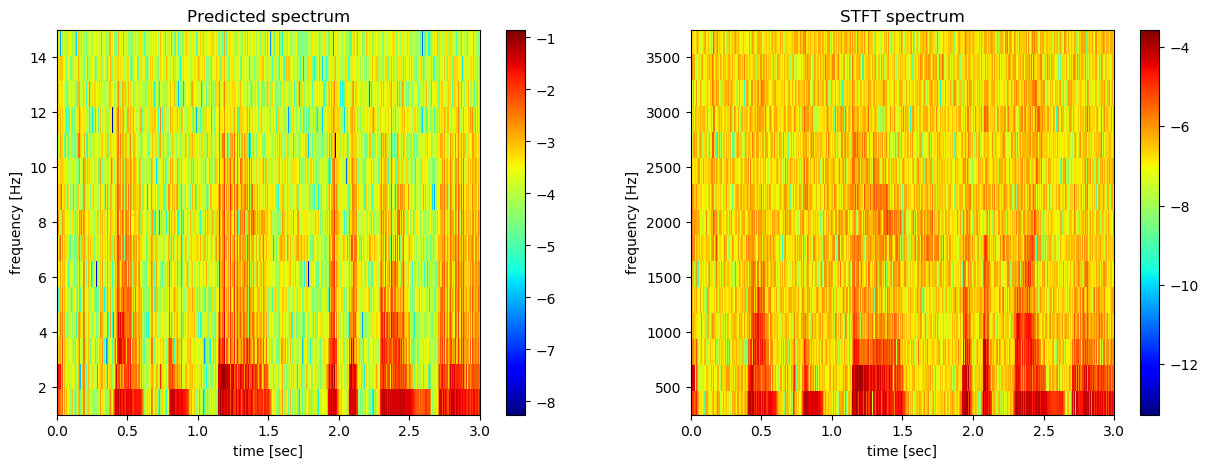

In [9]:
# convert μ_x to a 1d array
#μ_x_pred = expand((hcat(μ_x...),dims=1))

# convert s_x to a 2d array
if length(size(μ_s)) != 2
    μ_s = hcat(μ_s...)
end

# calculate magnitude spectrum
mag_μ_s = log10.((μ_s[1:length(freq),:].^2 + μ_s[length(freq)+1:end,:].^2))


# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
cmp = ax[1].imshow(mag_μ_s,
                   aspect="auto",
                   cmap="jet",
                   origin="lower",
                   extent=[minimum(t), maximum(t), 1, length(freq)])
fig.colorbar(cmp, ax=ax[1])

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 2*length(freq)+1, 0, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# change visuals
ax[1].set_xlim(minimum(t), maximum(t)), ax[2].set_ylim(minimum(freq), maximum(freq)), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency [Hz]"), ax[1].set_title("Predicted spectrum"), ax[2].set_title("STFT spectrum")
#cmp.set_clim(-3, -16)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQCcVbi9byvHvbS8AL4z2sq9L6dAvYXeMDukWUw9TosNPkEuTD7hYXc+EiOKPhcfdD5blIA+06IVPm5Ux7xMXi29PqG7vI5Sxr0jsTq+6aY9vkSxL70c/Ei8RQxzvB6dzLxOAuE9jDKePXeCPj1ghY08mIetvNYihr3y87W9SoTjvfuqJ746/aa91vKevWLSMbzkpqG73JTjPKVV0z21r34+CAcqPvm6UD5gKIg+PQqHPlmiWT63bIE9zyOAvGEvHr2+nQW+WBRrvsFbQr7FcfO97OqdveyGMb1Efdq9fLGMPY2AMD2FFMg8FrESPWdK/7xMJsC8vF4Tveh10b3Ub9O9PNo7vk/gW70g+GK97U1xvRYQgz3wIxA+M2VPPuYMMD5/BYo+6I+ZPj4lGz7qfTY9nhVIPEhfAD0pHv69rioRvsvSfr4oAze+TJizvRHAl71d2LK9/As/PBnE3D0uo809UIFvvDzjwTwo5Sk8AzD4PMPHRL3/PAa+Ax0WvqXho71wmee9n3Vmvd2s2jydLMo93/YHPjN+QD5fq4A+2bCAPoBMgj6jH9s90/NrPbLTDT0piBA8y1kSvk9uOb693za+soqnvYovyr2rhAS+GIAbvTbFgz1oFJw9e9uZPWjbCr32OD89unnmulpXy7xjF8O9+6OqvWzvljvMngk7xT06PLLY6z1QHtw9l/JCPm6wRj6HamQ+i4AMPhNBoz3F0t49ImlDvXbwD76X2E6+aQ3mvZipB75piDy+IeoivranI72EESU9Tri/PHT9zD3QbuE90UXxPPMknj2Peac8psbqvS4VoL1O27y9JWavvcW5Er4pNTm+N8M8u5HqLbuUdEc9Bi2CPVTn9D241fA98AwRPmUgoT2vRwo+8alJPXBNhz0xBLe9IQpqvSLgOb1xK8W9Uoy9vfWgkL35UFO9dDfHvRB0Sb1jWtc8jEYAPCOfILwWX4U9f5SfvPJum7zFGgC9bQdmug7x9zxh3eg9aWu3PXVPDj5R6GE+fo9xPjnVUj6TzFI95IoKPbRmuLxrJIu9BkJjvgABUL67eqS9SrQHvivB672Glca9pgkNPdJtqz2Lhck9OW4KPWR7Fj6Ltws+CbVOPWN0oT1Ifu68U3WavUHgvb00JQK+Tus/vtatkr0Xl3y8sku7vWYR7DwLcrK8iGOuPa2lFzwpi3+884mzPYyLVDuW6/i629VCvQoqCjyZoV48dRPMvIh/5zxcQH29cYxCvZJlnjyOLQ88Oqx3us2YxTyqRem8XJx6PVISKDwO4Cu9jkVgvb5sxLxZdty7FhB4ux7uXjwVwIm8L3xbPcgbrz0Uu+I95/OQPe6z7TzxVoU9b75mPfX5AD0JbYE790NOvJ3Hmb3ArZi8wpGFvSoe87txD0y6WxctvZ81J70h6gG9hcuPvBF2BT0DYZa8ZNOkvC03hDwtkzm8M4+FuzcYNz03yDQ9fHXqPfb7lz3Wx209XVIPPjDMTD0Rhog9+oqbPMljdjyHzYu9rOmKvTFi670KDrO9EtGvvU0X6r3RXui9HRKwvQ8wo71dtDK9iFiVPIUHUbu0kGK8louWPJz7fz07O249vXJiPRyJCD4VfHw9sKQEPhxr8D21kwI9vjzFPVG3vT1PHDG8De4JvaL4Br6KF5q9UyUHvvL2Qb4pER6+LQeQvbytILyXQ3i9SbCxPNKmRTuqzko9h5GoPZGLCj17Jek9lKZMPbDeyD3aVe09dNbSPY9gJD58ajA+8iEqPCkXizwL8Ck95fpqvYONMr6ZbN292LC3vUF8qL16h4C9KGbJvY1olTytlMC86rTruw3KtT2cnpI9Qnh0PXDcDbxktKs9trM1Pe8rlL0kwFe9sYWbvOUgNLl1N3y9WaUuvWGGgL1R+Xq8O6oRPK/qPDqnRLC8wyj7PJwweb1+RMo7YBwJPEQxfzpdEcE7fYE2POReCDzVdW48ErMbPB89srssFR48gXhHvTqHOz3GP7G9HIqcvTF3kr2kf0q8NlhLPJf1/DzDu167qhSxvHzndT1KVKI7nyKJPKkDmzx5yRi9kHbiPJnsFbygf2C91KJnPKO/kjvBvU49usQNPVGUj70LV8m9hAkQO80FIT0jdbO7w1uCu+KSvLwamGM8GJLwOywbmLsOB6g7i0i+PFVKvT2bm3I9L0unvPR9STwx9GE9lDgEPeT3wDvTcl88nOlSPfo6ury/nH08wq0VPG4XprwMfaY8/kKDPFxFqrzMH1y7MF49PCSTJLuSOmK8veemPJxzATy2rG68X3bvPP7B9Dzim3w8XaILvCjP7DzmGka8Yt6ZPecwyDzGzF+8Kzf7PEso8Lsmu5c943+qPR82ZLw5Q1w9bqwXvMj2vzxMKqI8QUJWPZ3cwDxrhKA77XLQPWxjtrzwzjK9jO5tvCH1vrxiTP+6QJd1vTitr72uteu6K4cBPT3SnLyFqPW8TwLoPA8OrTuz/gO83qSzuxlUTj0Z89G8tcwwvR6tjzzj7gI9Yz+ivFdXYbwGFYY8SWxnuoQS1rzieEy7ptLGPCC60Lwdvts8MJKyvKS4sLrlram6RPHyPKgGgL05nTY9HuANPPuykL1++l48wH7hvDzzv7yerN+7H+bpvL2dR7x9iUc8uFC1PGGGqrwYVhi8fF51OodzZrvW+Zo7xaoFPcBlhL0n0Vs8hKrCPLVTcT0Y3ro83mb8vMXdI73MEPQ8XUTxOnMUBL2hedU7GLM/vEZYtjrdS/k8hn+APJso1rsds0a8BdANvMenTrwyV848vxwQO5uFFD1q+S69P8NcvQk/Wb1d7/C8VUwDvTYzCjlQoCO81gOevVmxSryPmIS7gkCBvGOSirzh1xK9jRI8vRCQDz3PrUg80bRGvT684zyufgi93mtYvaGqRD3lmyO9R+i2PIqHET19MDC8rx4hO49XNb0jIwU938dPuwPkmLxHqP07PYx0vD7FY7yzt1C9FJm2O7i4YD2sdB28qgRGPDjaprzSy2y9mdxHvWQzCDz1NvW86vjGvJOFSTzE/vC7jodDPceuhTxnnxy7JFKVueHhvryk7/C8Ppo2vbinZjxtyqU5vieCvCSTj7vPVfC7e6AiPdX3ubmtOTG96vWovBHxnTymh6s7zaeFPWudE7uGO/Y7K8A4PYil3zxD3KI95/6Lvcvg5bzzJ4G8n4KavK2ghTtVTuE8TAQBPEeGBz3G4AM9iw0BvVn1P729bE29aASavBEMCD1vGw+8SK+PPRPEAT0UJr28OO8RO1nfrjyWR1k8XjFBPCYRMj18C+28HSdiu1ghkzxthUs8rxeMvDxIlTsayzI87w76PLvKfru4j7u9MRQmPXbuQz0ujkC75D+OOzf/Rr28G0c8IyM9vXwygby/tSK8Pz0ZvTXVj726U8s8wV8ovXMQ+7xgk5+8MapnPO8997zv6RY8dwbfu9CDbrvZ5n28mm6ZPMTpFj3NME07lRGiPGRCQDz7Zim9P0auO+9yQjym6fM8Pul/vG876byIeXQ92CwMO+9vgDzpao+8BBtPPOsE/jvfVwO9tpCKu89+F72ydnm7n2sFPcsA6zmWX6y807UdvN8gkbxYo928vhQnPHaUL71wev88QwPbvPBFHbyXru87efYHvSWzDD0uOie99g45vF3N/zxdB/E83xNMvdNtWT0ZoRS7x/kBPZ44zDx94kI9XV9HvaERzDw5oWw80BewPJh2pTyYXTQ9X0tYPM1KBr3OZRI8N/dGPbTL4bpS1mk8Pkf5PF/qYDzFsyk9c9jtu0aZ6rwCcyg9WcBjPGqjUjoSHDa9ncj+vEKEsru3BRc9RlxnveqnLjwp7Y67urRUvIgKVbx6cXs9XUqyO2CDTT1S5qO8kBKJPBubsDxkW

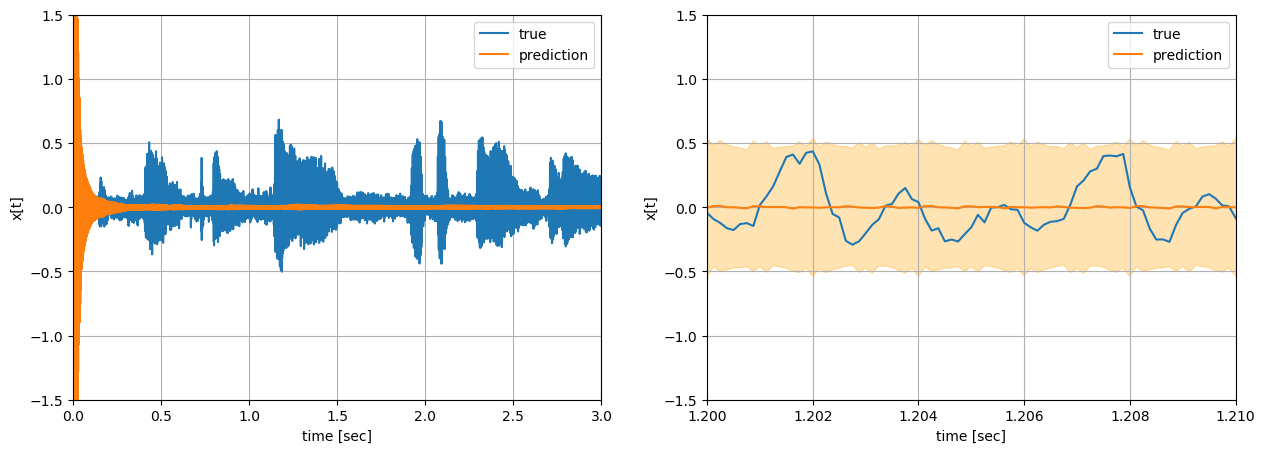

In [10]:
# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

μ_x_pred_select = simplify(reverse(hcat(μ_x...), dims=1))
var_x_pred_select = expand([reverse(diag(Σ_x[k])) for k =1:length(Σ_x)])

# plot actual, noisy and marginal of frequency component
ax[1].plot(t, x_time, label="true"), ax[1].plot(t[1:length(μ_x_pred_select)], μ_x_pred_select, label="prediction")#, ax[1].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")
ax[2].plot(t, x_time, label="true"), ax[2].plot(t[1:length(μ_x_pred_select)], μ_x_pred_select, label="prediction")#, ax[2].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")
ax[2].fill_between(t[1:length(μ_x_pred_select)], μ_x_pred_select .- sqrt.(var_x_pred_select), μ_x_pred_select .+ sqrt.(var_x_pred_select), alpha=0.3, color="orange")

# change vizualization
ax[1].grid(), ax[1].set_xlim(0,3), ax[1].set_ylim(-1.5, 1.5), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("x[t]"), ax[1].legend()
ax[2].grid(), ax[2].set_xlim(1.2,1.21), ax[2].set_ylim(-1.5, 1.5), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("x[t]"), ax[2].legend()

plt.savefig("figures/all_AR02.png", dpi=500)

# create audioplayers
audioplayers(x_time, x_time_clean, μ_x_pred_select, fs=fs_desired)
;

## Performance metrics

In [11]:
MSE = 1/length(μ_x_pred_select) * sum(abs.(μ_x_pred_select - x_time[1:length(μ_x_pred_select)]).^2)

0.06479114154705824

In [12]:
MAE = 1/length(μ_x_pred_select) * sum(abs.(μ_x_pred_select - x_time[1:length(μ_x_pred_select)]))

0.09302693578257054

In [13]:
using Distributions;
logBME = Float64[]
# initialize buffer
buf = BufferData(x_time, t, buffer_size)
for k = 1:length(μ_x)
    try 
        push!(logBME, sum([1/buffer_size*logpdf(Distributions.Normal(μ_x[k][ki], sqrt(Σ_x[k][ki,ki])), buf.buffer_s[ki]) for ki=1:buffer_size]))
    catch
    end
    step!(buf, step_size)
end
print("nr: "* string(length(logBME))* "       mean:"* string(mean(logBME)))

nr: 799       mean:-0.27593789626088405